# Studienprojekt 1 - Deep Reinforcement Learning Agent zum Schutz von E-Commerce Webanwendungen

In diesem Notebook wird ein Deep Q Network mit TF-Agents trainiert, um mögliche Kontoübernahmen (z.B. Bruteforce) zu erkennen.  
Zur Entwicklung wurde das Tutorial/Beispiel "Train a Deep Q Network with TF-Agents" von Tensorflow als Grundlage genutzt.  

Lizenz am Ende. Original auf: [TensorFlow.org](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial) oder [GitHub](https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb)

## Setup

In [1]:
%pip install tf-agents[reverb]==0.19.0
%pip install tf_keras==2.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 4.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 11.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 11.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 4.9 MB/s eta 0:00:00:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 10.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━

In [2]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import reverb

import tensorflow as tf
from tf_agents import trajectories as ts
from tf_agents.agents.dqn import dqn_agent
from tf_agents.specs import array_spec
from tf_agents.drivers import py_driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

2024-07-02 09:50:29.613901: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 09:50:29.616852: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 09:50:29.647341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 09:50:29.647378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 09:50:29.648206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Paramter

In [4]:
num_iterations = 20000

initial_collect_steps = 100
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 10
eval_interval = 1000

## Umgebung

Beim Reinforcement Learning (RL) stellt eine Umgebung die zu lösende Aufgabe oder das Problem dar. 


In [5]:
class LoginEnv(py_environment.PyEnvironment):
    def __init__(self):

        # Zustandseigenschaften: Richtiges Passwort (boolean), Zeit zwischen Loginversuchen (date), Falsches Passwort Zähler (int), letzte Aktion (int)
        self._observation_spec = array_spec.BoundedArraySpec(
                                shape=(4,), dtype=np.int32, minimum=0, name='observation')

        # Aktionen: 0 = Nicht sperren, 1 = 30s sperren, 2 = 1m sperren, 3 = 3min sperren, 4 = Dauerhaft sperren
        self._action_spec = array_spec.BoundedArraySpec(
                                shape=(), dtype=np.int32, minimum=0, maximum=4, name='action')

        # Interne Zustandsvariablen initialisieren
        self._state = np.array([0, 0, 0, 0], dtype=np.int32)
        self._episode_ended = False
        self._current_time_step = None

    def _reset(self):
        self._state[0] = np.random.choice([0, 1])  # Richtiges Passwort: 0 oder 1 (1=true)
        self._state[1] = np.random.randint(0, 3600)  # Zeit zwischen Loginversuchen
        self._state[2] = np.random.randint(0, 11)  # Falsches Passwort Zähler
        self._state[3] = np.random.randint(1, 3) if self._state[2] > 0 else 0  # Letzte Aktion
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.int32))

    def _step(self, action):
        if self._episode_ended:
            return self.reset()
        
        print(f"Richtiges Passwort: {self._state[0]}, Zeit zwischen Loginversuchen: {self._state[1]} Sekunden, Falsches Passwort Zähler: {self._state[2]}, Letzte Aktion: {self._state[3]}")
        
        reward = 0
        if action == 0:  # Nicht sperren
            print("Aktion 0")
            if self._state[0] == 1: # Richtiges Passwort
                reward = 1
                self._episode_ended = True
            elif self._state[1] <= 5 or self._state[2] >= 10 or self._state[3] >= 1: # Falsches Passwort UND: Weniger als 5s zwischen Loginversuchen oder mehr als 10 falsche Passwörter oder letzte Aktion war Sperren
                reward = -1
                self._episode_ended = True
            else:
                reward = 0
                self._episode_ended = True
        elif action == 1:  # 30s sperren
            print("Aktion 1")
            if self._state[0] == 1: # Richtiges Passwort
                reward = -1
                self._episode_ended = True
            elif self._state[1] <= 5 or (3 < self._state[2] <= 6): # Falsches Passwort UND: Weniger als 5s zwischen Loginversuchen oder 4-6 falsche Passwörter
                reward = 1
                self._episode_ended = True
            else:
                reward = 0
                self._episode_ended = True
        elif action == 2:  # 1m sperren
            print("Aktion 2")
            if self._state[0] == 1: # Richtiges Passwort
                reward = -1
                self._episode_ended = True
            elif 6 < self._state[2] <= 9: # Falsches Passwort UND: 7-9 falsche Passwörter
                reward = 1
                self._episode_ended = True
            else:
                reward = 0
                self._episode_ended = True
        elif action == 3:  # 3min sperren
            print("Aktion 3")
            if self._state[0] == 1: # Richtiges Passwort
                reward = -1
                self._episode_ended = True
            elif 9 < self._state[2] < 10: # Falsches Passwort UND: 10 falsche Passwörter
                reward = 1
                self._episode_ended = True
            else:
                reward = 0
                self._episode_ended = True
        elif action == 4:  # Dauerhaft sperren
            print("Aktion 4")
            if self._state[0] == 1: # Richtiges Passwort
                reward = -1
                self._episode_ended = True
            elif self._state[2] >= 10: # Falsches Passwort UND: Mehr als 10 falsche Passwörter
                reward = 1
                self._episode_ended = True
            else:
                reward = 0
                self._episode_ended = True

        if self._episode_ended:
            print("Episode beendet")
            return ts.termination(np.array(self._state, dtype=np.int32), reward)
        else:
            print("Episode nicht beendet")
            return ts.transition(np.array(self._state, dtype=np.int32), reward=0.0, discount=1.0)

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec


In der Regel werden zwei Umgebungen instanziiert: eine für das Training und eine für die Auswertung.

In [6]:
env = LoginEnv()
train_py_env = LoginEnv()
eval_py_env = LoginEnv()

Die Umgebung ist in reinem Python geschrieben. Sie wird mit Hilfe des `TFPyEnvironment` Wrappers in TensorFlow konvertiert.

Die API der ursprünglichen Umgebung verwendet Numpy-Arrays. Die `TFPyEnvironment` konvertiert diese in `Tensors`, um sie mit Tensorflow Agenten und Richtlinien kompatibel zu machen.

In [7]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

Der Algorithmus zur Lösung eines RL-Problems wird durch einen "Agenten" dargestellt. Der DQN-Agent kann in jeder Umgebung eingesetzt werden, die einen diskreten Aktionsraum hat.

Das Herzstück eines DQN-Agenten ist ein `QNetwork`, ein neuronales Netzmodell, das lernen kann, `QValues` (erwartete Erträge) für alle Aktionen vorherzusagen, wenn eine Beobachtung aus der Umgebung vorliegt.

Wir werden `tf_agents.networks.` verwenden, um ein `QNetwork` zu erstellen. Das Netzwerk besteht aus einer Folge von `tf.keras.layers.Dense`-Schichten, wobei die letzte Schicht einen Ausgang für jede mögliche Aktion hat.

In [8]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

Verwenden Sie nun `tf_agents.agents.dqn.dqn_agent`, um einen `DqnAgent` zu instanziieren. Zusätzlich zur `time_step_spec`, `action_spec` und dem QNetwork benötigt der Agentenkonstruktor auch einen Optimierer (in diesem Fall `AdamOptimizer`), eine Verlustfunktion und einen ganzzahligen Schrittzähler.

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

Eine Policy definiert die Art und Weise, wie ein Agent in einer Umgebung agiert. Normalerweise besteht das Ziel des Verstärkungslernens darin, das zugrunde liegende Modell so lange zu trainieren, bis die Strategie das gewünschte Ergebnis liefert.

Agenten enthalten zwei Richtlinien:

- `agent.policy` - Die Hauptrichtlinie, die für die Auswertung und den Einsatz verwendet wird.
- `agent.collect_policy` - Eine zweite Richtlinie, die für die Datenerfassung verwendet wird.


In [10]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies können aber auch unabhängig von Agenten erstellt werden:

In [11]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

## Metriken and Auswertung

Die gebräuchlichste Kennzahl zur Bewertung einer Strategie ist die durchschnittliche Rendite. Die Rendite ist die Summe der Belohnungen, die bei der Ausführung einer Strategie in einer Umgebung für eine Episode erzielt werden. Es werden mehrere Episoden ausgeführt, so dass eine durchschnittliche Rendite entsteht.

Die folgende Funktion berechnet die durchschnittliche Rendite einer Richtlinie, wenn die Richtlinie, die Umgebung und eine Anzahl von Episoden gegeben sind.


In [12]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

## Wiederholungspuffer

Um den Überblick über die von der Umgebung gesammelten Daten zu behalten, werden wir [Reverb](https://deepmind.com/research/open-source/Reverb) verwenden, ein effizientes, erweiterbares und einfach zu verwendendes Wiedergabesystem von Deepmind. Es speichert Erfahrungsdaten, wenn wir Trajektorien sammeln und wird während des Trainings verbraucht.

Dieser Replay-Puffer wird mit Hilfe von Spezifikationen aufgebaut, die die zu speichernden Tensoren beschreiben und die vom Agenten mit agent.collect_data_spec erhalten werden können.


In [13]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpdl6u82ur.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpdl6u82ur
[reverb/cc/platform/default/server.cc:71] Started replay server on port 42259


## Datensammlung

Nun wird die Zufallsrichtlinie in der Umgebung für einige Schritte ausgeführt und die Daten werden im Wiedergabepuffer aufgezeichnet.

Hier verwenden wir 'PyDriver', um die Erfahrungssammelschleife auszuführen. Mehr über den TF-Agententreiber erfahren Sie in dem [drivers tutorial](https://www.tensorflow.org/agents/tutorials/4_drivers_tutorial).

In [14]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 52 Sekunden, Falsches Passwort Zähler: 9, Letzte Aktion: 1
Aktion 0
Episode beendet
Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 413 Sekunden, Falsches Passwort Zähler: 3, Letzte Aktion: 2
Aktion 1
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 297 Sekunden, Falsches Passwort Zähler: 6, Letzte Aktion: 2
Aktion 0
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 1944 Sekunden, Falsches Passwort Zähler: 1, Letzte Aktion: 1
Aktion 0
Episode beendet
Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 87 Sekunden, Falsches Passwort Zähler: 2, Letzte Aktion: 2
Aktion 4
Episode beendet
Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 2416 Sekunden, Falsches Passwort Zähler: 7, Letzte Aktion: 2
Aktion 0
Episode beendet
Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 2773 Sekunden, Falsches Passwort Zähler: 8, Letzte Aktion: 1
Aktion 4
Episode beendet
Richtiges Passwort: 1, Zeit zwisc

(TimeStep(
 {'step_type': array(2, dtype=int32),
  'reward': array(-1., dtype=float32),
  'discount': array(0., dtype=float32),
  'observation': array([   1, 3327,    5,    2], dtype=int32)}),
 ())

Der Agent benötigt Zugriff auf den Wiedergabepuffer. Dies geschieht durch die Erstellung einer iterierbaren Pipeline "tf.data.Dataset", die den Agenten mit Daten versorgt.

Jede Zeile des Wiedergabepuffers speichert nur einen einzigen Beobachtungsschritt. Da der DQN-Agent jedoch sowohl die aktuelle als auch die nächste Beobachtung benötigt, um den Verlust zu berechnen, nimmt die Datensatz-Pipeline für jedes Element im Stapel zwei benachbarte Zeilen auf (`num_steps=2`).

Dieser Datensatz wird auch durch parallele Aufrufe und den Vorabruf von Daten optimiert.

In [15]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.int32, name=None),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [16]:
iterator = iter(dataset)
print(iterator)

## Agenten trainieren

Während der Trainingsschleife müssen zwei Dinge geschehen:

- Daten aus der Umgebung sammeln
- diese Daten verwenden, um das/die neuronale(n) Netz(e) des Agenten zu trainieren

In [17]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 2697 Sekunden, Falsches Passwort Zähler: 6, Letzte Aktion: 2
Aktion 2
Episode beendet
Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 3158 Sekunden, Falsches Passwort Zähler: 6, Letzte Aktion: 2
Aktion 2
Episode beendet
Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 1984 Sekunden, Falsches Passwort Zähler: 8, Letzte Aktion: 2
Aktion 2
Episode beendet
Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 1655 Sekunden, Falsches Passwort Zähler: 10, Letzte Aktion: 1
Aktion 2
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 832 Sekunden, Falsches Passwort Zähler: 9, Letzte Aktion: 1
Aktion 2
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 1602 Sekunden, Falsches Passwort Zähler: 3, Letzte Aktion: 2
Aktion 2
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 639 Sekunden, Falsches Passwort Zähler: 6, Letzte Aktion: 2
Aktion 2
Episode beendet
Richtiges Passwort: 1, Zeit 

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (12) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (12) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (12) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (12) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (12) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (12) so Table uniform_table is accessed directly without gRPC.


Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 3582 Sekunden, Falsches Passwort Zähler: 0, Letzte Aktion: 0
Aktion 2
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 302 Sekunden, Falsches Passwort Zähler: 5, Letzte Aktion: 2
Aktion 2
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 3459 Sekunden, Falsches Passwort Zähler: 10, Letzte Aktion: 1
Aktion 2
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 232 Sekunden, Falsches Passwort Zähler: 1, Letzte Aktion: 2
Aktion 1
Episode beendet
Richtiges Passwort: 0, Zeit zwischen Loginversuchen: 2842 Sekunden, Falsches Passwort Zähler: 7, Letzte Aktion: 1
Aktion 1
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 152 Sekunden, Falsches Passwort Zähler: 6, Letzte Aktion: 2
Aktion 1
Episode beendet
Richtiges Passwort: 1, Zeit zwischen Loginversuchen: 3105 Sekunden, Falsches Passwort Zähler: 2, Letzte Aktion: 2
Aktion 0
Episode beendet
Richtiges Passwort: 1, Zeit z

## Visualisierung

Die Bibliothek `matplotlib.pyplot` wird verwendet, um darzustellen, wie sich die Strategie während des Trainings verbessert hat.

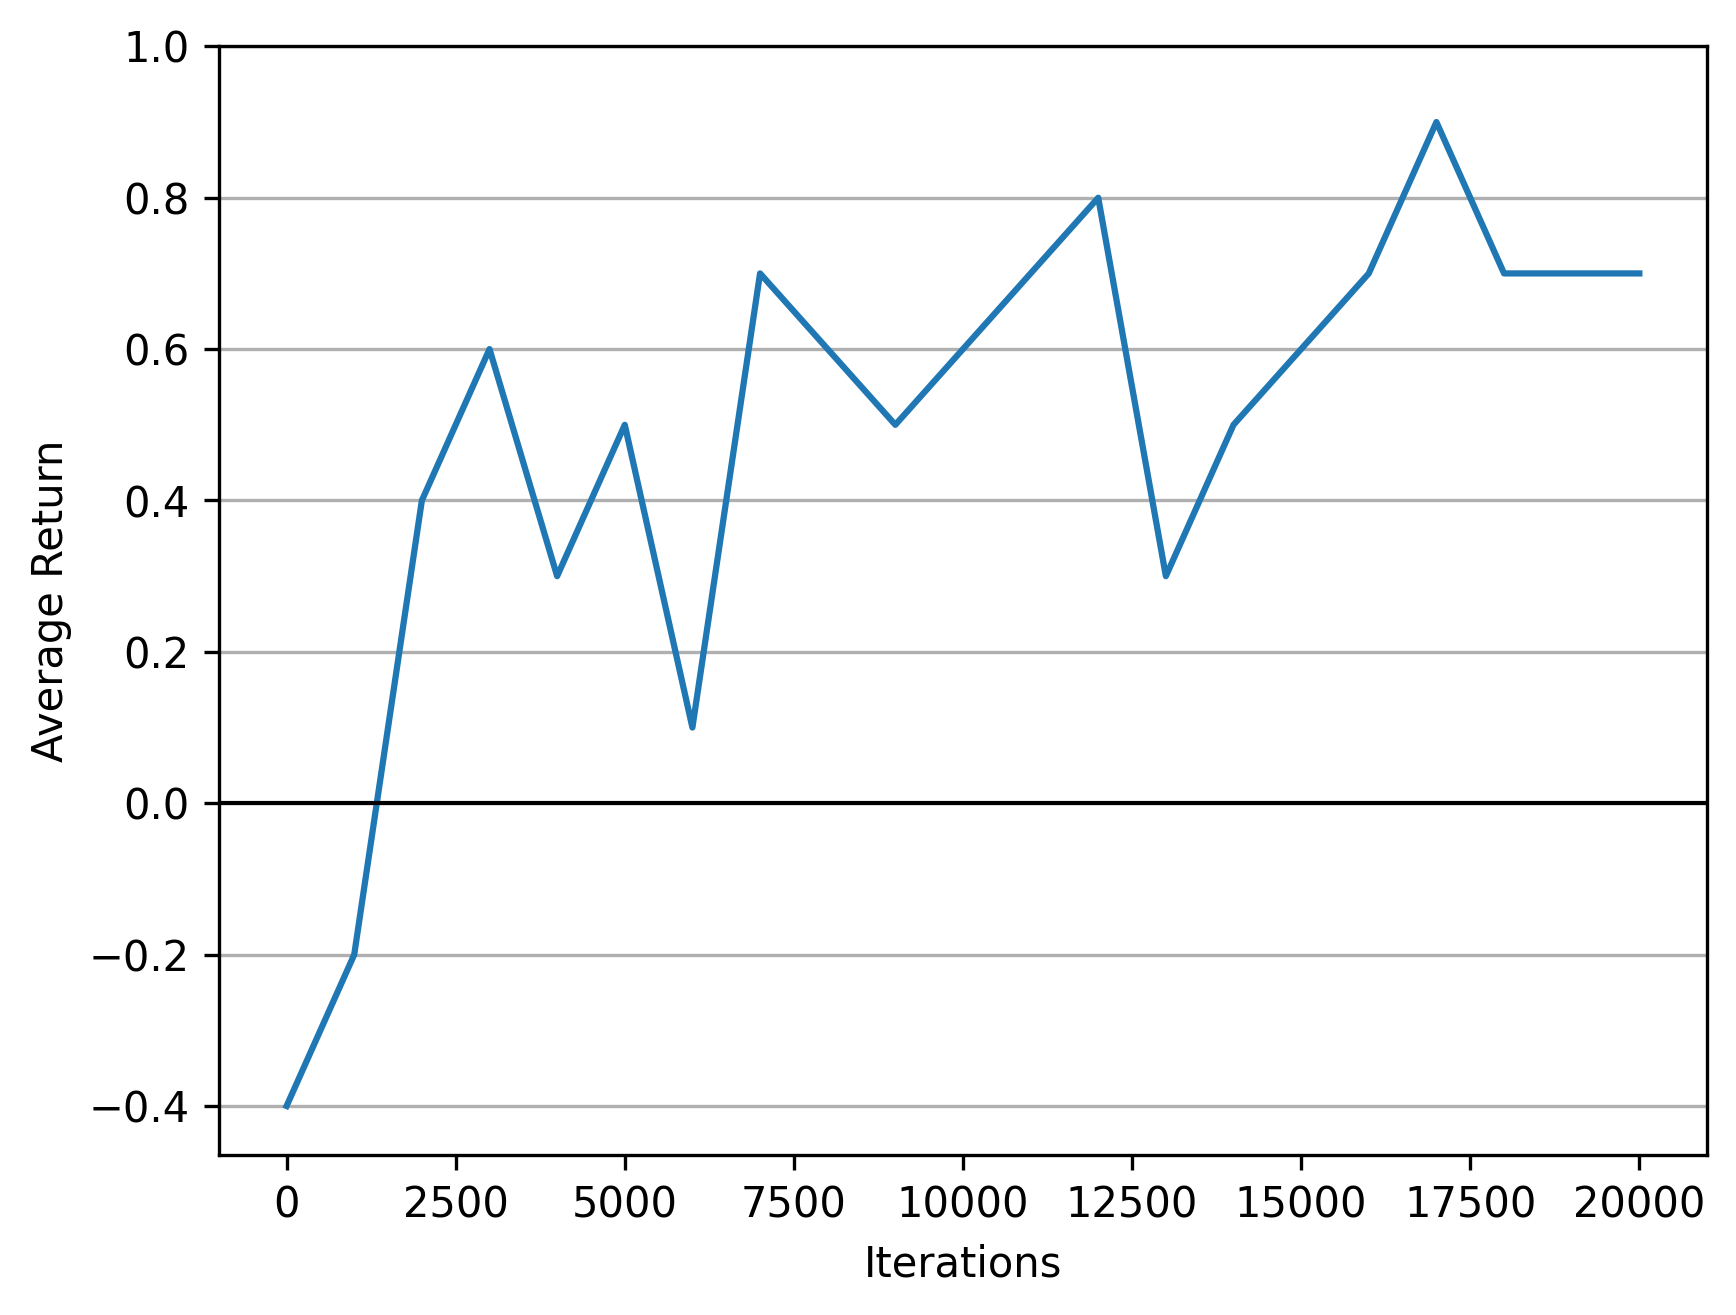

[reverb/cc/platform/default/server.cc:

In [18]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.figure(dpi=300)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=1)
plt.grid(True, which='major', axis='y')
plt.axhline(y=0, color='black', linewidth=1)

## Lizenz

```txt
   Copyright 2023 The TF-Agents Authors.

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```